<link rel="stylesheet" href="/site-assets/css/gemma.css">
<link rel="stylesheet" href="https://fonts.googleapis.com/css2?family=Google+Symbols:opsz,wght,FILL,GRAD@20..48,100..700,0..1,-50..200" />

Copyright 2024 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Generate PaliGemma output with Keras

<table class="tfo-notebook-buttons" align="left">
<td>
<a target="_blank" href="https://ai.google.dev/gemma/docs/paligemma/inference-with-keras"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on ai.google.dev</a>
</td>
<td>
<a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemma/docs/paligemma/inference-with-keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>
<td>
<a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/gemma/docs/paligemma/inference-with-keras.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td>
</table>

PaliGemma models have *multimodal* capabilities, allowing you to generate output using both text and image input data. You can use image data with these models to provide additional context for your requests, or use the model to  analyze the content of images. This tutorial shows you how to use PaliGemma with Keras to can analyze images and answer questions about them.

## What's in this notebook

This notebook uses PaliGemma with Keras and shows you how to:

* Install Keras and the required dependencies
* Download `PaliGemmaCausalLM`, a pre-trained PaliGemma variant for causal visual language modeling, and use it to create a model
* Test the model's ability to infer information about supplied images

## Before you begin

Before going through this notebook, you should be familiar with Python code, as well as how large language models (LLMs) are trained. You don't need to be familiar with Keras, but basic knowledge about Keras is helpful when reading through the example code.

## Setup

The following sections explain the preliminary steps for getting a notebook to use a PaliGemma model, including model access, getting an API key, and configuring the notebook runtime.

### Get access to PaliGemma

Before using PaliGemma for the first time, you must request access to the model through Kaggle by completing the following steps:

1. Log in to [Kaggle](https://www.kaggle.com), or create a new Kaggle account if you don't already have one.
1. Go to the [PaliGemma model card](https://www.kaggle.com/models/google/paligemma-2/) and click **Request Access**.
1. Complete the consent form and accept the terms and conditions.

### Configure your API key

To use PaliGemma, you must provide your Kaggle username and a Kaggle API key.

To generate a Kaggle API key, open your [**Settings** page in Kaggle](https://www.kaggle.com/settings) and click **Create New Token**. This triggers the download of a `kaggle.json` file containing your API credentials.

Then, in Colab, select **Secrets** (🔑) in the left pane and add your Kaggle username and Kaggle API key. Store your username under the name `KAGGLE_USERNAME` and your API key under the name `KAGGLE_KEY`.

### Select the runtime

To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to run the PaliGemma model. In this case, you can use a T4 GPU:

1. In the upper-right of the Colab window, click the **▾ (Additional connection options)** dropdown menu.
1. Select **Change runtime type**.
1. Under **Hardware accelerator**, select **T4 GPU**.

### Set environment variables

Set the environment variables for `KAGGLE_USERNAME`, `KAGGLE_KEY`, and `KERAS_BACKEND`.

In [ ]:
import os
from google.colab import userdata

# Set up environmental variables
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KERAS_BACKEND"] = "jax"

### Install Keras

Run the below cell to install Keras.

In [ ]:
!pip install -U -q keras-nlp kagglehub

### Import dependencies and configure Keras

Install the dependencies needed for this notebook and configure Keras' backend. You'll also set Keras to use `bfloat16` so that the framework uses less memory.

In [ ]:
import keras
import keras_hub
import numpy as np
import PIL
import requests
import io
import matplotlib
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

keras.config.set_floatx("bfloat16")

## Load the model

Now that you've set everything up, you can download the pre-trained model and create some utility methods to help your model generate its responses.
In this step, you download a model using `PaliGemmaCausalLM` from Keras Hub. This class helps you manage and run the causal visual language model structure of PaliGemma. A *causal visual language model* predicts the next token based on previous tokens. Keras Hub provides implementations of many popular [model architectures](https://keras.io/keras_hub/api/models/).


Create the model using the `from_preset` method and print its summary. This process will take about a minute to complete.

In [ ]:
paligemma = keras_hub.models.PaliGemmaCausalLM.from_preset("kaggle://keras/paligemma2/keras/pali_gemma_2_mix_3b_224")
paligemma.summary()

## Create utility methods

To help you generate responses from your model, create two utility methods:

*   **`crop_and_resize`:** Helper method for `read_img`. This method crops and resizes the image to the passed in size so that the final image is resized without skewing the proportions of the image.
*   **`read_img`:** Helper method for `read_img_from_url`. This method is what actually opens the image, resizes it so that it fits in the model's constraints, and puts it into an array that can be interpreted by the model.
*   **`read_img_from_url`:** Takes in an image via a valid URL. You need this method to pass the image to the model.

You'll use `read_img_from_url` in the next step of this notebook.


In [ ]:
def crop_and_resize(image, target_size):
    width, height = image.size
    source_size = min(image.size)
    left = width // 2 - source_size // 2
    top = height // 2 - source_size // 2
    right, bottom = left + source_size, top + source_size
    return image.resize(target_size, box=(left, top, right, bottom))

def read_image(url, target_size):
    contents = io.BytesIO(requests.get(url).content)
    image = PIL.Image.open(contents)
    image = crop_and_resize(image, target_size)
    image = np.array(image)
    # Remove alpha channel if necessary.
    if image.shape[2] == 4:
        image = image[:, :, :3]
    return image

def parse_bbox_and_labels(detokenized_output: str):
  matches = re.finditer(
      '<loc(?P<y0>\d\d\d\d)><loc(?P<x0>\d\d\d\d)><loc(?P<y1>\d\d\d\d)><loc(?P<x1>\d\d\d\d)>'
      ' (?P<label>.+?)( ;|$)',
      detokenized_output,
  )
  labels, boxes = [], []
  fmt = lambda x: float(x) / 1024.0
  for m in matches:
    d = m.groupdict()
    boxes.append([fmt(d['y0']), fmt(d['x0']), fmt(d['y1']), fmt(d['x1'])])
    labels.append(d['label'])
  return np.array(boxes), np.array(labels)

def display_boxes(image, boxes, labels, target_image_size):
  h, l = target_size
  fig, ax = plt.subplots()
  ax.imshow(image)
  for i in range(boxes.shape[0]):
      y, x, y2, x2 = (boxes[i]*h)
      width = x2 - x
      height = y2 - y
      # Create a Rectangle patch
      rect = patches.Rectangle((x, y),
                               width,
                               height,
                               linewidth=1,
                               edgecolor='r',
                               facecolor='none')
      # Add label
      plt.text(x, y, labels[i], color='red', fontsize=12)
      # Add the patch to the Axes
      ax.add_patch(rect)

  plt.show()

def display_segment_output(image, bounding_box, segment_mask, target_image_size):
    # Initialize a full mask with the target size
    full_mask = np.zeros(target_image_size, dtype=np.uint8)
    target_width, target_height = target_image_size

    for bbox, mask in zip(bounding_box, segment_mask):
        y1, x1, y2, x2 = bbox
        x1 = int(x1 * target_width)
        y1 = int(y1 * target_height)
        x2 = int(x2 * target_width)
        y2 = int(y2 * target_height)

        # Ensure mask is 2D before converting to Image
        if mask.ndim == 3:
            mask = mask.squeeze(axis=-1)
        mask = Image.fromarray(mask)
        mask = mask.resize((x2 - x1, y2 - y1), resample=Image.NEAREST)
        mask = np.array(mask)
        binary_mask = (mask > 0.5).astype(np.uint8)


        # Place the binary mask onto the full mask
        full_mask[y1:y2, x1:x2] = np.maximum(full_mask[y1:y2, x1:x2], binary_mask)
    cmap = plt.get_cmap('jet')
    colored_mask = cmap(full_mask / 1.0)
    colored_mask = (colored_mask[:, :, :3] * 255).astype(np.uint8)
    if isinstance(image, Image.Image):
        image = np.array(image)
    blended_image = image.copy()
    mask_indices = full_mask > 0
    alpha = 0.5

    for c in range(3):
        blended_image[:, :, c] = np.where(mask_indices,
                                          (1 - alpha) * image[:, :, c] + alpha * colored_mask[:, :, c],
                                          image[:, :, c])

    fig, ax = plt.subplots()
    ax.imshow(blended_image)
    plt.show()

## Generate output

After loading the model and creating utility methods, you can prompt the model with image and text data to generate a responses. PaliGemma models are trained with specific prompt syntax for specific tasks, such as `answer`, `caption`, and `detect`. For more information about PaliGemma prompt task syntax, see [PaliGemma prompt and system instructions](https://ai.google.dev/gemma/docs/paligemma/prompt-system-instructions##prompt_task_syntax).

Prepare an image for use in a generation prompt by using the following code to load a test image into an object:

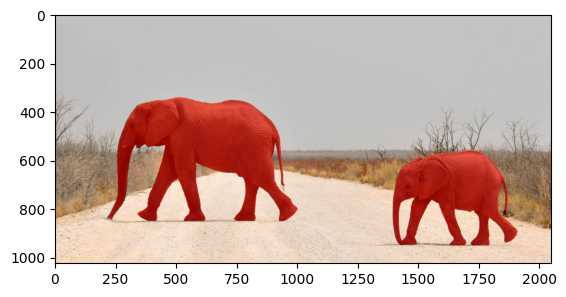

In [22]:
target_size = (224, 224)
# image_url = 'https://storage.googleapis.com/keras-cv/models/paligemma/cow_beach_1.png'
# cow_image = read_image(image_url, target_size)
# matplotlib.pyplot.imshow(cow_image)

image = np.asarray(PIL.Image.open('/prova.png'))
matplotlib.pyplot.imshow(image)

### Answer in a specific language

The following example code shows how to prompt the PaliGemma model for information about an object appearing in a provided image. This example uses the `answer {lang}` syntax and shows additional questions in other languages:

In [ ]:
prompt = 'answer en where is the cow standing?\n'
# prompt = 'svar no hvor står kuen?\n'
# prompt = 'answer fr quelle couleur est le ciel?\n'
# prompt = 'responda pt qual a cor do animal?\n'

output = paligemma.generate(
    inputs={
        "images": cow_image,
        "prompts": prompt,
    }
)
print(output)

Note: Prompts that use PaliGemma prompt command syntax must end with an "`\n`" character.

### Use `detect` prompt

The following example code uses the `detect` prompt syntax to locate an object in the provided image. The code uses the previously defined `parse_bbox_and_labels()` and `display_boxes()` functions to interpret the model output and display the generated bounding boxes.

In [ ]:
prompt = 'detect cow\n'
output = paligemma.generate(
    inputs={
        "images": cow_image,
        "prompts": prompt,
    }
)
boxes, labels = parse_bbox_and_labels(output)
display_boxes(cow_image, boxes, labels, target_size)

### Use `segment` prompt

The following example code uses the `segment` prompt syntax to locate the area of an image occupied by an object. It uses the Google `big_vision` library to interpret the model output and generate a mask for the segmented object.

Before getting started, install the `big_vision` library and its dependencies, as shown in this code example:


In [ ]:
import os
import sys

# TPUs with
if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")


# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"

For this segmentation example, load and prepare a different image that includes a cat.

In [ ]:
cat = read_image('https://big-vision-paligemma.hf.space/file=examples/barsik.jpg', target_size)
matplotlib.pyplot.imshow(cat)

Here is a function to help parse the segment output from PaliGemma

In [ ]:
import  big_vision.evaluators.proj.paligemma.transfers.segmentation as segeval
reconstruct_masks = segeval.get_reconstruct_masks('oi')
def parse_segments(detokenized_output: str) -> tuple[np.ndarray, np.ndarray]:
  matches = re.finditer(
      '<loc(?P<y0>\d\d\d\d)><loc(?P<x0>\d\d\d\d)><loc(?P<y1>\d\d\d\d)><loc(?P<x1>\d\d\d\d)>'
      + ''.join(f'<seg(?P<s{i}>\d\d\d)>' for i in range(16)),
      detokenized_output,
  )
  boxes, segs = [], []
  fmt_box = lambda x: float(x) / 1024.0
  for m in matches:
    d = m.groupdict()
    boxes.append([fmt_box(d['y0']), fmt_box(d['x0']), fmt_box(d['y1']), fmt_box(d['x1'])])
    segs.append([int(d[f's{i}']) for i in range(16)])
  return np.array(boxes), np.array(reconstruct_masks(np.array(segs)))

Query PaliGemma to segment the cat in the image

In [ ]:
prompt = 'segment cat\n'
output = paligemma.generate(
    inputs={
        "images": cat,
        "prompts": prompt,
    }
)

Visualize the generated mask from PaliGemma

In [ ]:
bboxes, seg_masks = parse_segments(output)
display_segment_output(cat, bboxes, seg_masks, target_size)

### Batch prompts

You can provide more than one prompt command within a single prompt as a batch of instructions. The following example demonstrates how to structure your prompt text to provide multiple instructions.

Important: Each prompt command must end with an "\n" character, as shown.

In [ ]:
prompts = [
    'answer en where is the cow standing?\n',
    'answer en what color is the cow?\n',
    'describe en\n',
    'detect cow\n',
    'segment cow\n',
]
images = [cow_image, cow_image, cow_image, cow_image, cow_image]
outputs = paligemma.generate(
    inputs={
        "images": images,
        "prompts": prompts,
    }
)
for output in outputs:
    print(output)